<a href="https://colab.research.google.com/github/Keshigami/500-AI-Machine-learning-Deep-learning-Computer-vision-NLP-Projects-with-code/blob/main/vehicle_detection_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Create parent folder for custom model training and child folders to store data

In [ ]:
import shutil
shutil.unpack_archive("Images.zip")
#/content/Images.zip

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

### Prepare the dataset for model training

In [ ]:
####Step 2: Load and preprocess the data

# Load the labels from labels.csv
labels_df = pd.read_csv('labels.csv', sep=',', header=None)
labels_df.columns = ['image_id', 'class', 'x_min', 'y_min', 'x_max', 'y_max']

# Adjust the image IDs in the dataframe
labels_df['image_id'] = labels_df['image_id'].apply(lambda x: f"{x:08d}")

# Use iloc to pick the first 1000 labels
labels_df = labels_df.iloc[:1000]

# Load the corresponding images
images_dir = 'Images/'
images = []
for index, row in labels_df.iterrows():
    img_path = os.path.join(images_dir, f"{row['image_id']}.jpg")
    img = cv2.imread(img_path)
    if img is not None:
        images.append(img)
    else:
        print(f"Error loading image: {img_path}")

# Check if images are loaded
if len(images) == 0:
    print("No images loaded. Please check the image paths.")
else:
    print(f"{len(images)} images loaded successfully.")

1000 images loaded successfully.


In [ ]:
# Analyze the distribution of vehicle types in the limited dataset
vehicle_types = labels_df['class'].value_counts()
print("Distribution of vehicle types:")
print(vehicle_types)

# Address data quality issues arising from the discrepancy between labels and actual image filenames
# Sorting the image filenames
labels_df = labels_df.sort_values('image_id')


Distribution of vehicle types:
class
car                      682
pickup_truck             111
motorized_vehicle         61
articulated_truck         30
work_van                  29
bus                       28
pedestrian                23
single_unit_truck         18
bicycle                   12
non-motorized_vehicle      5
motorcycle                 1
Name: count, dtype: int64


In [ ]:
if len(images) > 0:
    processed_images = [cv2.resize(img, (224, 224)) for img in images]  # Adjust dimensions as needed
    processed_images = np.array(processed_images)
    print("Images resized successfully.")

Images resized successfully.


In [ ]:
labels = labels_df['class'].to_numpy()
bounding_boxes = labels_df[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()

# Convert labels to one-hot encoding
unique_labels = np.unique(labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}
index_to_label = {index: label for index, label in enumerate(unique_labels)}
labels = np.array([label_to_index[label] for label in labels])

In [ ]:
unique_labels

array(['articulated_truck', 'bicycle', 'bus', 'car', 'motorcycle',
       'motorized_vehicle', 'non-motorized_vehicle', 'pedestrian',
       'pickup_truck', 'single_unit_truck', 'work_van'], dtype=object)

In [ ]:
X_train, X_test, y_train, y_test, bbox_train, bbox_test = train_test_split(processed_images, labels, bounding_boxes, test_size=0.2, random_state=42)

In [ ]:
from keras.layers import BatchNormalization

#### Create an CNN architecture for object detection

In [ ]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(128, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    vehicle_class = layers.Dense(num_classes, activation='softmax', name='vehicle_class')(x)
    bounding_box = layers.Dense(4, name='bounding_box')(x)

    model = keras.Model(inputs=inputs, outputs=[vehicle_class, bounding_box])
    return model

input_shape = processed_images[0].shape
num_classes = len(unique_labels)
model = create_model(input_shape, num_classes)

'''
model.compile(optimizer='adam',
              loss={'vehicle_class': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

model.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train}, epochs=10, validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}))
'''

"\nmodel.compile(optimizer='adam',\n              loss={'vehicle_class': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'},\n              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})\n\nmodel.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train}, epochs=10, validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}))\n"

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 222, 222,  │      3,584 │ input_layer_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 111, 111,  │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │        512 │ max_pooling2d_11… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 109, 109,  │     73,792 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 54, 54,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        256 │ max_pooling2d_12… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 52, 52,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 26, 26,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │        256 │ max_pooling2d_13… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 24, 24,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 12, 12,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 10, 10,    │     36,928 │ max_pooling2d_14… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 6400)      │          0 │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │    409,664 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vehicle_class       │ (None, 11)        │        715 │ dropout_1[0][0] 

 Total params: 600,079 (2.29 MB)

 Trainable params: 599,439 (2.29 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
model.compile(optimizer='adam',
              loss={'vehicle_class': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

In [ ]:
model.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train}, epochs=20, validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}))

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - bounding_box_loss: 91557.9688 - bounding_box_mae: 238.5106 - loss: 91561.1875 - vehicle_class_accuracy: 0.0638 - vehicle_class_loss: 3.2344 - val_bounding_box_loss: 96891.2266 - val_bounding_box_mae: 239.0949 - val_loss: 94201.1562 - val_vehicle_class_accuracy: 0.0050 - val_vehicle_class_loss: 43.1250
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - bounding_box_loss: 90769.8047 - bounding_box_mae: 236.8102 - loss: 90772.7188 - vehicle_class_accuracy: 0.0946 - vehicle_class_loss: 2.9139 - val_bounding_box_loss: 89233.0703 - val_bounding_box_mae: 225.4955 - val_loss: 86712.5312 - val_vehicle_class_accuracy: 0.0350 - val_vehicle_class_loss: 12.7779
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - bounding_box_loss: 90884.3359 - bounding_box_mae: 238.0655 - loss: 90887.1094 - vehicle_class_accuracy: 0.1246 - vehicle_class_loss: 2.7683 - val_bounding_box_loss: 99418.8594 - val_bounding_box_mae: 247.5144 - val_loss: 96650.6719

#### Evaluate the model and check the test results

In [ ]:
test_results = model.evaluate(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose=2)
print('\nTest results:', test_results)

7/7 - 0s - 33ms/step - bounding_box_loss: 84079.7500 - bounding_box_mae: 228.7704 - loss: 82344.3359 - vehicle_class_accuracy: 0.6800 - vehicle_class_loss: 1.2317

Test results: [82344.3359375, 1.2316807508468628, 84079.75, 228.7704315185547, 0.6800000071525574]


In [ ]:
model.predict(X_test[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


[array([[2.4472699e-02, 9.1677730e-04, 1.4702904e-02, 7.5057858e-01,
         4.0012627e-04, 5.0004639e-02, 1.9177252e-03, 6.2992927e-03,
         1.1896289e-01, 2.1433957e-02, 1.0310402e-02]], dtype=float32),
 array([[15.471442, 17.76429 , 20.810938, 22.944107]], dtype=float32)]

#### Run inferences on the images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


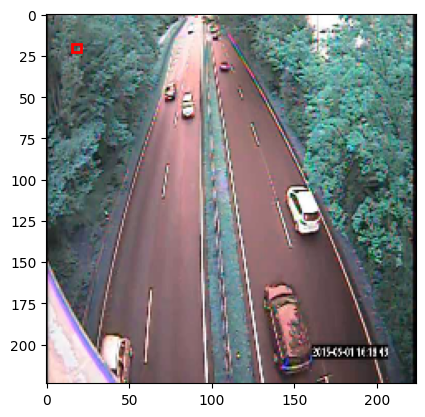

In [ ]:
import matplotlib.pyplot as plt

# Choose a few sample images for inference
sample_images = X_test[:1]  # Adjust the number of sample images as needed

# Perform inference on the sample images
predictions = model.predict(sample_images)

# Extract the predicted bounding box coordinates
predicted_bounding_boxes = predictions[1]

# Visualize the sample images with predicted bounding boxes
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i])
    plt.gca().add_patch(plt.Rectangle((predicted_bounding_boxes[i][0], predicted_bounding_boxes[i][1]),
                                     predicted_bounding_boxes[i][2] - predicted_bounding_boxes[i][0],
                                     predicted_bounding_boxes[i][3] - predicted_bounding_boxes[i][1],
                                     fill=False, edgecolor='r', linewidth=2))
    plt.show()